In [1]:
laa_names = ['Bour', 'Calhoun', 'Fletcher', 'Garneau', 'Lucroy', 'Pujols', 
'Simmons', 'Trout', 'Upton']

In [2]:
from pymongo import MongoClient

In [3]:
import pandas as pd

In [21]:
import re

In [47]:
import pymongo 
import pandas as pd

def get_from_db(collection, query_dict, fields_return_dict, db_name):
    client = pymongo.MongoClient('localhost', 27017)
    db = client[db_name] #select database
    db_collection = db[collection] #select the collection within the databse
    df = pd.DataFrame(list(db_collection.find(query_dict,fields_return_dict))) #convert entire collection to pandas DataFrame
    return df

In [65]:
fields_return_dict = {"_id":0,"mlb_name":1, "bref_id":1}
db_name = 'MLB'
collection = 'player_name_and_ids'

df = pd.DataFrame()
for i in laa_names:
    regx = re.compile("{}$".format(i))
    query_dict = {"mlb_name" : regx, 'mlb_team' : 'LAA'}
    query_df = get_from_db(collection, query_dict, fields_return_dict, db_name)
    df = df.append(query_df)

df
    

,bref_id,mlb_name
0,bourju01,Justin Bour
0,calhoko01,Kole Calhoun
0,fletcda02,David Fletcher
0,garnedu01,Dustin Garneau
0,lucrojo01,Jonathan Lucroy
0,pujolal01,Albert Pujols
0,simmoan01,Andrelton Simmons
0,troutmi01,Mike Trout
0,uptonju01,Justin Upton


In [188]:
for index, row in df.iterrows():
    print(row['bref_id'][0], row['bref_id'])

b bourju01
c calhoko01
f fletcda02
g garnedu01
l lucrojo01
p pujolal01
s simmoan01
t troutmi01
u uptonju01


In [75]:
from bs4 import BeautifulSoup
import urllib

In [189]:
def br_standard_batting(letter, player):
    url ="https://www.baseball-reference.com/players/{}/{}.shtml".format(letter, player)
    page = urllib.request.urlopen(url)
    soup = BeautifulSoup(page,'html.parser')

    header = soup.find('table', id="batting_standard").find('thead').find('tr').text.split('\n')
    header = header[2:-1] # drop first and last item
    header

    table = soup.find('table', id="batting_standard")
    table_rows = table.find('tbody').find_all('tr', id=re.compile("batting_standard"))

    data = []
    for row in table_rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append(cols)

    data = pd.DataFrame(data=data, columns = header)

    year_rows = table.find('tbody').find_all('tr', {'id' : re.compile('batting_standard.\d{4}')})

    year = []
    for y in year_rows:
        yrs = y.find_all('th')
        yrs = [yr.text.strip() for yr in yrs]
        year.append(yrs)
    flat_year = [item for sublist in year for item in sublist]

    data['Year'] = flat_year

    data[['Year', 'Age', 'G', 'PA',
         'AB', 'R', 'H', '2B', '3B', 
          'HR', 'RBI', 'SB', 'CS', 
          'BB', 'SO', 'TB', 'GDP',
         'HBP', 'SH', 'SF', 'IBB', 'OPS+']] = data[['Year', 'Age', 'G', 'PA',
                                            'AB', 'R', 'H', '2B', '3B',
                                            'HR', 'RBI', 'SB', 'CS',
                                            'BB', 'SO', 'TB', 'GDP',
                                            'HBP', 'SH', 'SF', 'IBB', 'OPS+']].astype(int)

    data[['BA', 'OBP', 'SLG', 'OPS']] = data[['BA', 'OBP', 'SLG', 'OPS']].astype(float)
    
    return(data)


In [171]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 30 columns):
Age       6 non-null int32
Tm        6 non-null object
Lg        6 non-null object
G         6 non-null int32
PA        6 non-null int32
AB        6 non-null int32
R         6 non-null int32
H         6 non-null int32
2B        6 non-null int32
3B        6 non-null int32
HR        6 non-null int32
RBI       6 non-null int32
SB        6 non-null int32
CS        6 non-null int32
BB        6 non-null int32
SO        6 non-null int32
BA        6 non-null float64
OBP       6 non-null float64
SLG       6 non-null float64
OPS       6 non-null float64
OPS+      6 non-null int32
TB        6 non-null int32
GDP       6 non-null int32
HBP       6 non-null int32
SH        6 non-null int32
SF        6 non-null int32
IBB       6 non-null int32
Pos       6 non-null object
Awards    6 non-null object
Year      6 non-null int32
dtypes: float64(4), int32(22), object(4)
memory usage: 992.0+ bytes


In [172]:
data

,Age,Tm,Lg,G,PA,AB,R,H,2B,3B,...,OPS+,TB,GDP,HBP,SH,SF,IBB,Pos,Awards,Year
0,26,MIA,NL,39,83,74,10,21,3,0,...,105,27,0,0,0,0,1,3/D,,2014
1,27,MIA,NL,129,446,409,42,107,20,0,...,120,196,19,2,0,1,3,*3/D,RoY-5,2015
2,28,MIA,NL,90,321,280,35,74,12,1,...,124,133,8,0,0,3,9,3/D,,2016
3,29,MIA,NL,108,429,377,52,109,18,0,...,143,202,10,1,0,4,7,3/D,,2017
4,30,TOT,NL,141,501,423,49,96,13,1,...,108,171,10,2,0,3,6,*3/D,,2018
5,31,LAA,AL,42,153,137,16,25,5,0,...,72,54,7,1,0,1,0,3/D,,2019


In [174]:
data = br_standard_batting('bourju01')
data

,Age,Tm,Lg,G,PA,AB,R,H,2B,3B,...,OPS+,TB,GDP,HBP,SH,SF,IBB,Pos,Awards,Year
0,26,MIA,NL,39,83,74,10,21,3,0,...,105,27,0,0,0,0,1,3/D,,2014
1,27,MIA,NL,129,446,409,42,107,20,0,...,120,196,19,2,0,1,3,*3/D,RoY-5,2015
2,28,MIA,NL,90,321,280,35,74,12,1,...,124,133,8,0,0,3,9,3/D,,2016
3,29,MIA,NL,108,429,377,52,109,18,0,...,143,202,10,1,0,4,7,3/D,,2017
4,30,TOT,NL,141,501,423,49,96,13,1,...,108,171,10,2,0,3,6,*3/D,,2018
5,31,LAA,AL,42,153,137,16,25,5,0,...,72,54,7,1,0,1,0,3/D,,2019


In [194]:
for index, row in df.iterrows():
    print(row['bref_id'][0], row['bref_id'])

b bourju01
c calhoko01
f fletcda02
g garnedu01
l lucrojo01
p pujolal01
s simmoan01
t troutmi01
u uptonju01


In [209]:
data = pd.DataFrame()
for index, row in df.iterrows():
    player_dat = br_standard_batting("{}".format(row['bref_id'][0]), "{}".format(row['bref_id']))
    data = data.append(player_dat)

data

,Age,Tm,Lg,G,PA,AB,R,H,2B,3B,...,OPS+,TB,GDP,HBP,SH,SF,IBB,Pos,Awards,Year
0,26,MIA,NL,39,83,74,10,21,3,0,...,105,27,0,0,0,0,1,3/D,,2014
1,27,MIA,NL,129,446,409,42,107,20,0,...,120,196,19,2,0,1,3,*3/D,RoY-5,2015
2,28,MIA,NL,90,321,280,35,74,12,1,...,124,133,8,0,0,3,9,3/D,,2016
3,29,MIA,NL,108,429,377,52,109,18,0,...,143,202,10,1,0,4,7,3/D,,2017
4,30,TOT,NL,141,501,423,49,96,13,1,...,108,171,10,2,0,3,6,*3/D,,2018
5,31,LAA,AL,42,153,137,16,25,5,0,...,72,54,7,1,0,1,0,3/D,,2019
0,24,LAA,AL,21,25,23,2,4,1,0,...,31,5,0,0,0,0,1,9/7D,,2012
1,25,LAA,AL,58,222,195,29,55,7,2,...,128,90,6,1,0,5,0,9/3,,2013
2,26,LAA,AL,127,537,493,90,134,31,3,...,123,222,5,2,2,2,0,*9/3,,2014
3,27,LAA,AL,159,686,630,78,161,23,2,...,104,266,6,5,2,4,1,*9/3D,GG,2015


In [212]:
dat = data[data['Year']==2019]
dat

,Age,Tm,Lg,G,PA,AB,R,H,2B,3B,...,OPS+,TB,GDP,HBP,SH,SF,IBB,Pos,Awards,Year
5,31,LAA,AL,42,153,137,16,25,5,0,...,72,54,7,1,0,1,0,3/D,,2019
7,31,LAA,AL,85,354,310,51,73,16,1,...,110,148,3,3,0,2,5,*9/8,,2019
1,25,LAA,AL,83,323,293,43,85,13,2,...,102,117,6,0,0,1,1,5476/9,,2019
4,31,LAA,AL,16,46,38,6,10,2,0,...,94,12,1,3,0,0,0,2,,2019
9,33,LAA,AL,72,260,232,27,54,6,0,...,75,81,15,4,0,3,0,*2/3D,,2019
18,39,LAA,AL,70,290,256,30,60,10,0,...,92,109,12,2,0,6,1,3D,,2019
7,29,LAA,AL,54,224,215,25,60,13,0,...,87,85,14,1,0,0,0,6/D,,2019
8,27,LAA,AL,86,385,297,69,89,18,1,...,186,187,5,10,0,2,11,*8/D,AS,2019
12,31,LAA,AL,14,58,52,7,14,1,0,...,114,24,0,0,0,0,0,7/D,,2019


In [214]:
prob_hit = dat['H'] / dat['PA']

In [215]:
df['mlb_name']

0          Justin Bour
0         Kole Calhoun
0       David Fletcher
0       Dustin Garneau
0      Jonathan Lucroy
0        Albert Pujols
0    Andrelton Simmons
0           Mike Trout
0         Justin Upton
Name: mlb_name, dtype: object

In [244]:
stan_data = pd.DataFrame(data=dat[['H', 'PA']], columns = ['H', 'PA'])

In [245]:
stan_data = stan_data.reset_index()

In [246]:
stan_data

,index,H,PA
0,5,25,153
1,7,73,354
2,1,85,323
3,4,10,46
4,9,54,260
5,18,60,290
6,7,60,224
7,8,89,385
8,12,14,58


In [247]:
name = df['mlb_name']
name = name.reset_index()
name = name['mlb_name']
name

0          Justin Bour
1         Kole Calhoun
2       David Fletcher
3       Dustin Garneau
4      Jonathan Lucroy
5        Albert Pujols
6    Andrelton Simmons
7           Mike Trout
8         Justin Upton
Name: mlb_name, dtype: object

In [248]:
stan_data['name'] = name
stan_data

,index,H,PA,name
0,5,25,153,Justin Bour
1,7,73,354,Kole Calhoun
2,1,85,323,David Fletcher
3,4,10,46,Dustin Garneau
4,9,54,260,Jonathan Lucroy
5,18,60,290,Albert Pujols
6,7,60,224,Andrelton Simmons
7,8,89,385,Mike Trout
8,12,14,58,Justin Upton


In [249]:
stan_data = stan_data[['H', 'PA', 'name']]
stan_data

,H,PA,name
0,25,153,Justin Bour
1,73,354,Kole Calhoun
2,85,323,David Fletcher
3,10,46,Dustin Garneau
4,54,260,Jonathan Lucroy
5,60,290,Albert Pujols
6,60,224,Andrelton Simmons
7,89,385,Mike Trout
8,14,58,Justin Upton


In [241]:
import pystan

In [250]:
N = 9
K = stan_data['PA']
y = stan_data['H']

In [253]:
baseball_dat = { 'N': N,
               'K' : K,
               'y' : y}

In [255]:
baseball_code = """
data {
    int<lower=0> N; // number of players
    int<lower=0> K[N]; // initial trials
    int<lower=0> y[N]; // initial successes
}
parameters {
  real<lower=0, upper=1> phi;         // population chance of success
  real<lower=1> kappa;                // population concentration
  vector<lower=0, upper=1>[N] theta;  // chance of success 
}
model {
  kappa ~ pareto(1, 1.5);                        // hyperprior
  theta ~ beta(phi * kappa, (1 - phi) * kappa);  // prior
  y ~ binomial(K, theta);                        // likelihood
}
"""

In [256]:
sm = pystan.StanModel(model_code = baseball_code)
fit = sm.sampling(data = baseball_dat, iter = 1000, chains = 4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_07618315693b93c16b4de461a7cc58a6 NOW.
C:\Users\Nicholas\AppData\Local\Continuum\anaconda3\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Nicholas\AppData\Local\Temp\tmp3c51yojj\stanfit4anon_model_07618315693b93c16b4de461a7cc58a6_4414839107291216494.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [257]:
import matplotlib 
import scipy

In [259]:
print(fit)

Inference for Stan model: anon_model_07618315693b93c16b4de461a7cc58a6.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
phi        0.23  5.3e-4   0.02   0.19   0.22   0.23   0.24   0.27   1379    1.0
kappa    203.54   39.74 503.07  15.83  54.35  104.4 198.37 836.26    160   1.02
theta[1]   0.19  7.6e-4   0.03   0.13   0.17   0.19   0.21   0.24   1320    1.0
theta[2]   0.21  4.1e-4   0.02   0.17    0.2   0.21   0.22   0.25   2190    1.0
theta[3]   0.25  5.6e-4   0.02   0.21   0.24   0.25   0.27    0.3   1630    1.0
theta[4]   0.22  8.5e-4   0.04   0.15    0.2   0.22   0.25    0.3   1924    1.0
theta[5]   0.21  5.5e-4   0.02   0.17    0.2   0.21   0.23   0.26   1739    1.0
theta[6]   0.21  4.9e-4   0.02   0.17    0.2   0.21   0.23   0.25   1759    1.0
theta[7]   0.25  6.9e-4   0.03   0.21   0.24   0.25   0.27   0.31   1412    1.0
theta[8]   0.

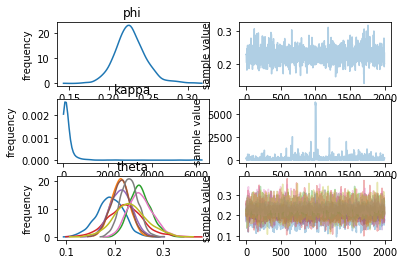

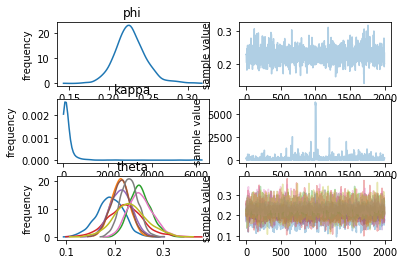

In [260]:
fit.plot()